## Librerias

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import cm
import cv2
from obspy import read
import numpy as np
import pandas as pd
import random as rng
import seaborn as sns

## Funciones a utilizar 

In [2]:
def get_tr(path):
    ###
    #Esta funcion obtiene una variable st a partir de un archivo .mseed
    #Luego obtiene las traces de dicho archivo
    # Filtra el st segun una freq min y max
    # obtiene las traces del archivo filtrado y las retorna.
    ###
    st = read(path)
    tr = st.traces[0].copy()
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin = 0.5, freqmax = 1.0)
    tr_filt = st.traces[0].copy()
    return tr_filt

In [3]:
def imagen(tr_filt, axv1 = None, axv2 = None):
    ###
    #Esta función hace un plot 2d:
    # x: relative time
    # y : frecuencia hz
    #Luego guarda la funcion en una imagen.
    #Carga la imagen en una variable
    #Recorta el cuadrado de información de la imagen.
    # Devuelve la imagen en formato np.array
    ###

    tr_times_filt = tr_filt.times()
    tr_time_len = max(tr_times_filt)
    tr_data_filt = tr_filt.data
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

    # Calcular el valor máximo para usarlo en vmax (si es necesario)
    vmax_val = np.max(sxx)
    # Creo la gráfica sin mostrarla
    fig, ax2 = plt.subplots()
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=vmax_val)
    ax2.set_xlim([min(tr_times_filt), max(tr_times_filt)])
    ax2.set_xlabel('Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')

    if axv1 and axv2:     
        ax2.axvline(axv1, c = 'red')
        ax2.axvline(axv2, c = 'green')
    plt.savefig('imagen.png')
    plt.close(fig)
    
    imagen = cv2.imread('imagen.png', cv2.IMREAD_GRAYSCALE)
    x_0  = 81
    x_1  = 574
    y_0 = 259
    y_1 = 425
    imagen =imagen[y_0:y_1,x_0:x_1]

    return imagen, tr_time_len



In [4]:
def sec_x_pix(img, tr_filt):
    ###
    #Esta función saca la proporción seg / pixel
    # a partir de una imagen dada y de un trace filtrado
    ###
    len = img.shape[1]
    sec = max(tr_filt.times())
    sxp = sec / len
    return sxp

In [5]:
def imadjust(image,vout=[0,255], gamma=1):
    # image: imagen en escalas de grises.
    # vout: Límites de los valores de intensidad de la imagen de salida
    # img_ajustada     : Imagen de salida
    vin = [image.min(), image.max()]
    img_ajustada = (((image - vin[0]) / (vin[1] - vin[0])) ** gamma) * (vout[1] - vout[0]) + vout[0]
    img_ajustada[image<vin[0]] = vout[0]   # Valores menores que el mínimo se mapean a 0
    img_ajustada[image>vin[1]] = vout[1]   # Valores mayores que el maximo se mapean a 255
    if image.dtype==np.uint8:
       img_ajustada = np.uint8(np.clip(np.round(img_ajustada), 0, 255))   # Numpy underflows/overflows para valores fuera de rango, se debe utilizar clip.
    return img_ajustada

In [6]:
def detect(image,type_mq, sh = None):
    ###
    # Esta función detecta aquellos sectores de la imagen.
    # que tienen frecuencia sísmica que se destaca.
    # Lo hace detectando cambios en la imagen.
    # Encuentra los contornos y dibuja rectángulos sobre
    # las áreas detectadas.
    # Devuelve los valores min y max del eje x entre todos los contornos.
    # si sh = True, plotea la imagen del/los rectángulo/s detectado/S
    ###
    if type_mq == 'impact_mq':
        t2 = 0.3
        kernel = (3,3)
        minim_area = 4
        sigma = 2
    if type_mq == 'deep_mq':
        t2 = 0.2
        kernel = (5,5)
        minim_area = 7
        sigma = 2
    if type_mq== 'shallow_mq':
        minim_area = 4
        t2 = 0.2
        kernel = (3,3)
        sigma = 2
    if type_mq == 'mars':
        minim_area = 10
        t2 =0.7
        kernel = (7,7)
        sigma = 2
    if type_mq == 'else':
        t2 = 0.2
        kernel = (5,5)
        minim_area = 4
        sigma = 2


    # Copia de la imagen original
    im_graf = image.copy()
    
    # Ajuste de contraste
    img_umbralada = imadjust(im_graf)
    
    # Aplicar Gaussian Blur
    img_blur = cv2.GaussianBlur(img_umbralada, kernel, sigma)  # Aumentar el tamaño del kernel y el sigma
    
    # Aplicar Canny con umbrales ajustados
    img_canny = cv2.Canny(img_blur, threshold1=0.05 * 255, threshold2=t2*255)  # Umbrales fijos en lugar de proporcionales
    
    # Encontrar contornos
    contours, _ = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Inicializar listas
    positions_x = []
    boundRect = []

    for c in contours:
        # Filtrar contornos pequeños
        if cv2.contourArea(c) > minim_area:  # Filtrar contornos menores a un área de 100 píxeles
            # Aproximar contornos a polígonos y obtener el rectángulo de contorno
            contours_poly = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly))

    # Calcular posiciones x
    for i in boundRect:
        x_0 = i[0]
        x_1 = i[0] + i[2]
        positions_x.append(x_0)
        positions_x.append(x_1)

    # Determinar los valores mínimos y máximos
    x_min = min(positions_x) if positions_x else None
    x_max = max(positions_x) if positions_x else None

    # Crear imagen de dibujo
    drawing = np.zeros((img_canny.shape[0], img_canny.shape[1], 3), dtype=np.uint8)
    

    # Dibujar los rectángulos alrededor de los contornos
    for i in boundRect:
        color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        cv2.rectangle(drawing, (i[0], i[1]), (i[0] + i[2], i[1] + i[3]), color, 1)

    if sh:    
        # Mostrar la imagen con contornos
        plt.imshow(cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Desactivar los ejes
        plt.show()
    

    return x_min, x_max


In [7]:
def arrival_end(x_min,x_max, sxp):
    ###
    #Esta función pasa el valor x_min y x_max
    # a valor relative(sec)
    # a raíz de una propoción segundo por pixel
    ###
    arrival = x_min*sxp
    end = x_max*sxp
    return arrival,end

In [8]:
def detect_arrival_end_catalog(path_catalog, type, sh = False):
    ###
    #Esta función ejecuta todas las funciones anteriores para cada dato del dataset training
    # mencionado en el catalogo pasado como path.
    ###
    catalog = pd.read_csv(path_catalog)
    if type == 'lunar':
        path = f'data/{type}/training/data/S12_GradeA/'
    else:
        path = f'data/{type}/training/data/'
    arrival_list = []
    end_list = [] 
    time_len_list = []
    for i in range(len(catalog)):
        file = catalog.iloc[i].filename
        if type == 'lunar':
            mq_type = catalog.iloc[i].mq_type
            if file == 'xa.s12.00.mhz.1971-04-13HR00_evid00029':
                file = 'xa.s12.00.mhz.1971-04-13HR02_evid00029'
            path_file = f'{path}{file}.mseed'

        else:
            mq_type = 'mars'
            path_file = f'{path}{file[:-4]}.mseed'

        tr_filt = get_tr(path_file)
        img, time_len = imagen(tr_filt, sh)
        sxp = sec_x_pix(img, tr_filt)
        x_min, x_max= detect(img, mq_type)
        arrival, end = arrival_end(x_min,x_max,sxp)
        # Agregar los resultados a las listas
        time_len_list.append(time_len)
        arrival_list.append(arrival)
        end_list.append(end)
    catalog['arrival_img'] = arrival_list
    catalog['end_img'] = end_list
    catalog['len_time'] = time_len_list
    return catalog      

## Deteccion arrival y end para Lunar train

Se realiza la detección de arrival y end para cada archivo del catálogo training de moon

In [9]:
path_c_moon = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
moon_catalog_sub = detect_arrival_end_catalog(path_c_moon, type= 'lunar', sh = True)

Se calculan las diferencias entre los arrivals detectados y los reales.

In [10]:
moon_catalog_sub['Diferencia'] = abs(moon_catalog_sub['time_rel(sec)']-moon_catalog_sub['arrival_img'])

In [11]:
#Descomentar estas secciones si se quiere ver el df entero.

#pd.set_option('display.max_rows', None)  # Mostrar todas las filas
#pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
moon_catalog_sub['Ventana'] = moon_catalog_sub['end_img'] - moon_catalog_sub['arrival_img']


In [12]:
moon_catalog_sub['Diferencia_tasa'] = 100 - moon_catalog_sub['Ventana']*100 / 600000

In [13]:
moon_catalog_sub['Ahorro'] = 1 - (moon_catalog_sub['Ventana'] / moon_catalog_sub['len_time'])

Se obtiene el ahorro de datos promedio

In [14]:
ahorro_prom = np.mean(moon_catalog_sub['Ahorro'])
ahorro_prom

0.7139158748798975

In [15]:
moon_catalog_sub

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type,arrival_img,end_img,len_time,Diferencia,Ventana,Diferencia_tasa,Ahorro
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq,73783.549007,75536.127368,86402.113208,283.549007,1752.578361,99.707904,0.979716
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq,12793.732634,82195.350760,86401.509434,73.732634,69401.618125,88.433064,0.196755
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq,73432.520188,75360.342914,86401.509434,412.520188,1927.822726,99.678696,0.977688
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq,4381.445903,60288.695626,86402.113208,58.554097,55907.249723,90.682125,0.352941
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq,52226.470206,53628.523097,86401.509434,86.470206,1402.052891,99.766325,0.983773
...,...,...,...,...,...,...,...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq,63969.445444,65196.256726,86402.566038,189.445444,1226.811282,99.795531,0.985801
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq,66248.387921,68351.511348,86403.320755,548.387921,2103.123426,99.649479,0.975659
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq,36629.079720,38732.184776,86402.566038,329.079720,2103.105056,99.649482,0.975659
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq,57834.681771,58360.451605,86401.509434,54.681771,525.769834,99.912372,0.993915


Se obtiene el promedio de las diferencias para ver el promedio de error en arrivals.

In [16]:
mean = np.mean(moon_catalog_sub['Diferencia'])
mean

11743.734922479762

Vemos la distribución de las diferencias para ver las arrivals detectadas muy mal

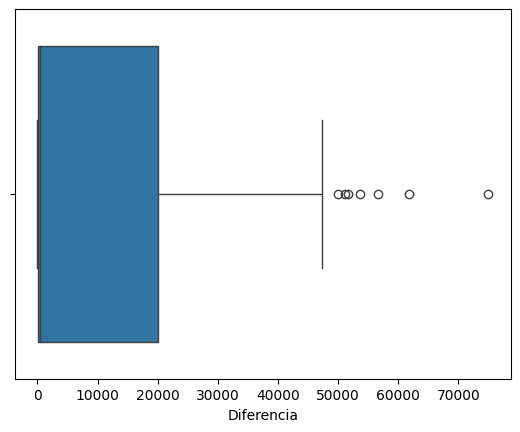

In [17]:
sns.boxplot(moon_catalog_sub, x='Diferencia')
q1 = moon_catalog_sub['Diferencia'].quantile(q = 0.25)
q3 = moon_catalog_sub['Diferencia'].quantile(q = 0.75)
ric = q3 - q1
lower_bound = q1 - 1.5 * ric
upper_bound = q3 + 1.5 * ric    

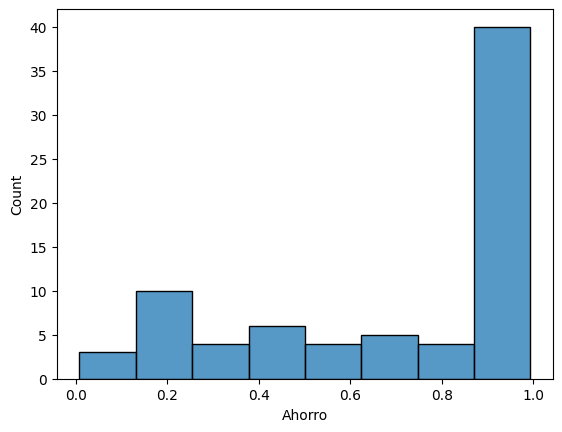

In [18]:
sns.histplot(moon_catalog_sub, x='Ahorro')  

In [19]:
np.median(moon_catalog_sub['Ahorro'])

0.9310344827586208

<Axes: xlabel='Ahorro', ylabel='Count'>

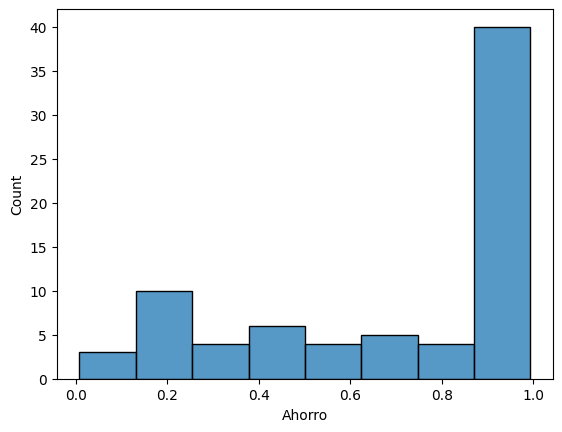

In [20]:
sns.histplot(moon_catalog_sub['Ahorro'])

## Detecciones vs tiempos reales

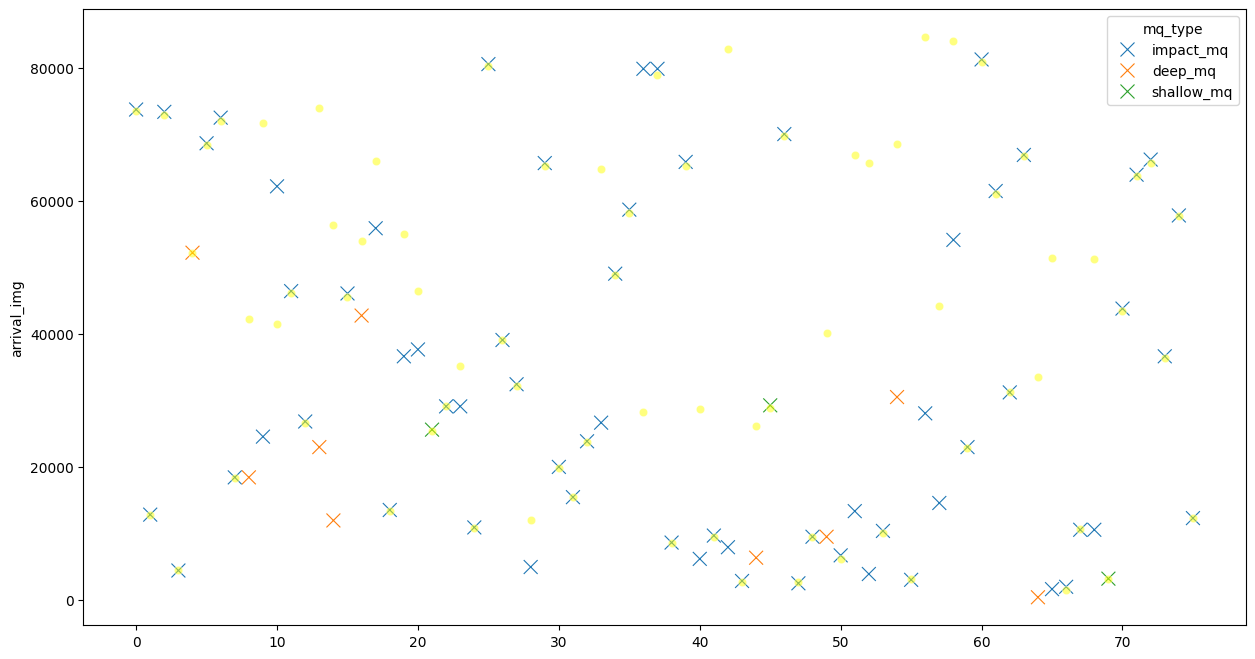

In [55]:
plt.figure(figsize=(15, 8))

# Primer scatterplot con 'x' y hue basado en mq_type
sns.scatterplot(x=range(len(moon_catalog_sub['arrival_img'])), 
                y=moon_catalog_sub['arrival_img'], 
                hue=moon_catalog_sub['mq_type'],
                marker='x', 
                s=100,  # tamaño de los puntos
                legend='full'  # muestra leyenda completa
                )

moon_catalog_sub['time_rel(sec)']
# Segundo scatterplot para destacar todos los puntos en amarillo
sns.scatterplot(x=range(len(moon_catalog_sub['time_rel(sec)'])), 
                y=moon_catalog_sub['time_rel(sec)'], 
                color='yellow', 
                alpha=0.5,  # añade transparencia para ver los puntos debajo
                legend=False  # no mostrar leyenda
                )

plt.show()



Filtramos los datos que se consideran atípicos (muy mal detectados)

In [37]:
q1 = moon_catalog_sub['Diferencia'].quantile(q = 0.25)
q3 = moon_catalog_sub['Diferencia'].quantile(q = 0.75)
ric = q3 - q1
lower_bound = q1 - 1.5 * ric
upper_bound = q3 + 1.5 * ric  

In [38]:
moon_catalog_sub_filtred = moon_catalog_sub[(moon_catalog_sub['Diferencia'] >= lower_bound) & (moon_catalog_sub['Diferencia'] <= upper_bound)]

Observamos la cantidad y proporcion de arrivals muy mal detectados

In [39]:
cant_mal_marcados = len(moon_catalog_sub) - len(moon_catalog_sub_filtred)
cant_mal_marcados

7

Obtenemos un promedio de diferencia sin tener en cuenta los arrivals muy mal detectados

In [41]:
promedio_sin_atipicos = np.mean(moon_catalog_sub_filtred['Diferencia'])
promedio_sin_atipicos

7141.253362220111

## Deteccion arrival y end para mars train

In [27]:
mars_ex = read('./data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed')

In [28]:
mars_ex[0]

XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples

In [29]:
image, len_t = imagen(mars_ex[0])

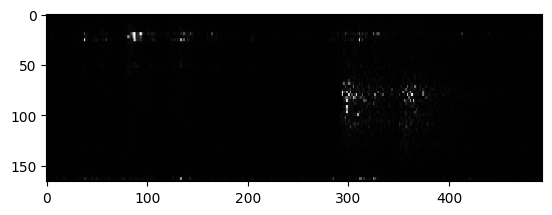

(<Figure size 640x480 with 1 Axes>,
 None)

In [30]:
plt.figure(),plt.imshow(image, cmap = 'gray'), plt.show()

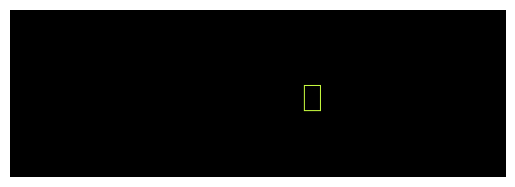

(292, 308)

In [31]:
detect(image, type_mq='mars', sh = True)

In [32]:
mars_c_path = './data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'

mars_c_sub = detect_arrival_end_catalog(mars_c_path, type= 'mars')

In [33]:
mars_c_sub['Diferencia'] = abs(mars_c_sub['time_rel(sec)'] - mars_c_sub['end_img'])

In [34]:
mars_c_sub

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,arrival_img,end_img,len_time,Diferencia
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005,679.098073,737.515112,3599.95,230.515112
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006,2132.221907,2249.055984,3599.95,119.055984


In [35]:
np.mean(mars_c_sub['Diferencia'])

174.78554766734266